In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import scipy.stats as stats
from tqdm import tqdm

from collections import defaultdict
from scipy.stats.stats import pearsonr

## Loading the dataset

In [ ]:
df = pd.read_csv("../dataset/customer_supermarket.csv", sep="\t", index_col=0, parse_dates=["BasketDate"], decimal=",")

## Attributes and check

In [ ]:
df.dtypes

Here we can have an idea of data types we are going to use

| Attribute       | Type       |
|-----------------|------------|
| BasketID        | int64      |
| BasketDate      | datetime64 |
| Sale            | float64    |
| CustomerID      | int64      |
| CustomerCountry | object     |
| ProdID          | object     |
| ProdDescr       | object     |
| Qta             | int64      |

as we can see there are problems in the attribute values, so we have to evaluate what prevents us from getting the desired data types:

The execution df['BasketID'].astype(int) tell us that some rows contains literal inside the attribute BasketID, this means the data type cannot be converted to int

## Checking NaN values and duplicates

It is possible to evaluate the quality of the data from the point of view of the rows, based on two aspects:
- missing or partial value (NaN/Null values)
- duplicates
- duplicates products in the same basket

Any duplicates or rows with missing values are temporarily removed from the dataset to allow for better evaluation

In [ ]:
# check if there are duplicates
areduplicates = df.duplicated().any()

# duplicates have been removed from the data set
df_nodup = df.drop_duplicates()

# check if there are missing or incomplete values
arenan = df.isnull().values.any()

# rows with missing or incomplete values have been removed from the data set
df_clean = df_nodup.dropna()

print("There are duplicates: ", areduplicates, "Number or rows removed: ", len(df)-len(df_nodup))
print("There are NaN/Null: ", arenan, "Number or rows removed: ", len(df_nodup)-len(df_clean))

nmb_of_rmv_rows = len(df)-len(df_clean)

print("Number of rows with apparent problems to solve:", 100*nmb_of_rmv_rows/len(df), "%")


df_Sale_Qta_merge = df_clean.groupby(['BasketID','BasketDate','ProdID']).agg({'Qta':np.sum,
                                                                         'Sale':np.sum,
                                                                         'CustomerID':'min',
                                                                         'CustomerCountry':'min',
                                                                         'ProdDescr':'min'}).reset_index()

df_Sale_Qta_merge.to_csv("../dataset/customer_supermarket_sale_qta_merge.csv")

print(f"Number of duplicates inside baskets {len(df_clean) - len(df_Sale_Qta_merge)}")

## Checking data consistency

Here we are verifing that the dataset is consistent:

1. Every ProdID must match the same ProdDescr
2. Every CustomerID must match the same BasketID in the same BasketDate
3. Every CustomerID must match the same CustomerCountry

In [ ]:
def inconsistent_set(K,V):
    
    inconsistentset = set()

    for key in tqdm(df_Sale_Qta_merge[K].unique().tolist()):
        temp_df = df_Sale_Qta_merge[df_Sale_Qta_merge[K] == key]
        valueslist = temp_df[V].tolist()
        for value in valueslist:
            if(valueslist[0] != value):
                inconsistentset.add(key)
                break;
    return inconsistentset


# 1
ProdID_ProdDescr_IS = inconsistent_set("ProdID","ProdDescr")
            
print("Number of not consistent ProdDescr:", len(ProdID_ProdDescr_IS))


#2 True == no error
temp = df_Sale_Qta_merge.groupby(['BasketID','BasketDate']).CustomerID.nunique().eq(1)
print(temp.all())

#3 
CustomerID_CustomerCountry_IS = inconsistent_set("CustomerID","CustomerCountry")
            
print("Number of not consistent CustomerCountry:", len(CustomerID_CustomerCountry_IS))

## Converting attributes to correct data type

Here we are changing the type of attributes. This imply a little cleaning phase over BasketID because there are characters inside the values

In [ ]:
df_Sale_Qta_merge['CustomerID'] = pd.to_numeric(df_Sale_Qta_merge.CustomerID)
df_Sale_Qta_merge.CustomerID = df_Sale_Qta_merge.CustomerID.astype(int)

The only attribute that still has a wrong datatype is BasketID, we have to remove letters at the beginning of the ID.

In [41]:
# regex matchin everything except digits
regex = "\D+"
df_regex = pd.DataFrame(df_Sale_Qta_merge)
df_regex['BasketID'] = df_regex['BasketID'].replace(to_replace=r'\D+', value='', regex=True)
df_regex.BasketID = pd.to_numeric(df_regex.BasketID)
df_regex.info()
df_regex.to_csv("../dataset/customer_supermarket_regex.csv")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396687 entries, 0 to 396686
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   BasketID         396687 non-null  int64         
 1   BasketDate       396687 non-null  datetime64[ns]
 2   ProdID           396687 non-null  object        
 3   Qta              396687 non-null  int64         
 4   Sale             396687 non-null  float64       
 5   CustomerID       396687 non-null  int64         
 6   CustomerCountry  396687 non-null  object        
 7   ProdDescr        396687 non-null  object        
 8   Outlier          329 non-null     object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(4)
memory usage: 27.2+ MB


## Statistics and data understanding (maybe Data preparation???)

Here are informations about quantities

In [ ]:
print("Number of clients: ",len(df_regex['CustomerID'].unique()))
print("Number of products: ",len(df_regex['ProdID'].unique()))
print("Number of purchase: ",len(df_regex['BasketID'].unique()))
print("Distinct values in Customer Country: \t", len(df_regex.CustomerCountry.unique()))
#print("Distinct values in ProdID: \t", df_clean.ProdID.unique())
#print("Distinct values in ProdDescr: \t", df_clean.ProdDescr.unique())

We have people coming from unspecified countries, a generic "European Community", EIRE which stands for Ireland and RSA which stands for Republic of South Africa.

In [ ]:
print("Number of customers from Unspecified countries: \t", (df_clean.CustomerCountry == "Unspecified").sum())
print("Number of customers from generic European Community countries: \t", (df_clean.CustomerCountry == "European Community").sum())


In [ ]:
df_regex.describe()

## Correlation

### Correlation matrix

In [ ]:
correlations = df_regex.corr(method="pearson")
correlations

In [ ]:
#plt.scatter(df_regex['Qta'], df_regex['Sale'], color='g', marker='*', label='Dinner')

temp = pd.DataFrame()
temp['Result'] = df_regex['Sale']/df_regex['Qta']

qta_mean = df_regex['Qta'].mean()
sale_mean = df_regex['Sale'].mean()

plt.scatter(df_regex[df_regex['Qta'] < qta_mean+1000]['Qta'], 
            df_regex[df_regex['Sale'] < sale_mean+1000 ]['Sale'], color='g', marker='*')

plt.scatter(df_regex[df_regex['Qta'] > qta_mean+1000]['Qta'], 
            df_regex[df_regex['Sale'] > sale_mean+1000]['Sale'], color='r', marker='*')

plt.xlabel('Qta')
plt.ylabel('Sale')
plt.legend()
plt.show()

In [ ]:
boxplot = df_regex.boxplot()

In [ ]:
pd.plotting.scatter_matrix(df_regex[['BasketID', 'CustomerID', 'Qta', 'Sale']])
plt.show()

In [ ]:
temp = df_regex.groupby('CustomerCountry').CustomerID.nunique().reset_index()
print(type(temp))
#temp.plot(kind='bar', title='Size Counts')
plt.bar(temp['CustomerCountry'],temp['CustomerID'])
plt.show()

There seems to be absolutely no correlation between the values of the dataset

In [ ]:
import seaborn as sns

cmap = sns.color_palette("Blues")
sns.heatmap(correlations, annot=True, cmap=cmap)
plt.show()

We clearly have a problem with outliers

Seems like we have a lot of problems with outliers in Sale and Qta rows.
We proceed to filter them out.

In [ ]:
from sklearn.cluster import DBSCAN
from collections import Counter

data = df_regex.iloc[:,]

In [ ]:
import scipy

z = np.abs(scipy.stats.zscore(df_regex[['Qta','Sale']]))
filtered = np.where(z > 3)
print(z)
print(filtered)

In [ ]:
print(z[3462][0])

In [39]:
qta_std = df_regex['Qta'].std()
qta_mean = df_regex['Qta'].mean()

sale_std = df_regex['Sale'].std()
sale_mean = df_regex['Sale'].mean()

print("QTA STD: ", qta_std, " QTA MEAN: ", qta_mean)
print("SALE STD: ", sale_std, " SALE MEAN: ", sale_mean)

threshold = 15

def outliers_zscore(qta,sale):
    
    qta_z_score = (qta - qta_mean) / qta_std
    if(np.abs(qta_z_score) > threshold):
        return True
    
    sale_z_score = (sale - sale_mean) / sale_std
    if(np.abs(sale_z_score) > threshold):
        return True
    
    return False
    
df_regex['Outlier'] = df_regex.apply(lambda x: outliers_zscore(x['Qta'],x['Sale']), axis=1)



QTA STD:  251.83768934373637  QTA MEAN:  12.334288746543244
SALE STD:  71.14848439529611  SALE MEAN:  3.5171706004986305


No handles with labels found to put in legend.


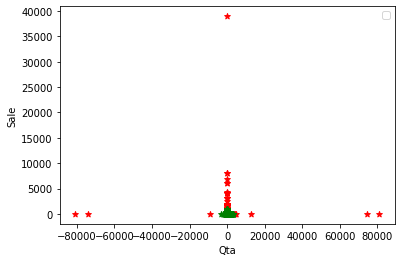

In [40]:
outliers_df = df_regex[df_regex['Outlier'] == True]
notoutliers_df = df_regex[df_regex['Outlier'] == False]

plt.scatter(outliers_df['Qta'],outliers_df['Sale'], color='r', marker='*')

plt.scatter(notoutliers_df['Qta'],notoutliers_df['Sale'], color='g', marker='*')


plt.xlabel('Qta')
plt.ylabel('Sale')
plt.legend()
plt.show()

In [ ]:
import scipy

zscores = scipy.stats.zscore(df_regex)
abs_zscores = np.abs(zscore)
filtered_outliers = (abs_zscores < 3).all(axis = 1)

df_no_outliers = df_regex(filtered_outliers)

In [ ]:
df_no_outliers.describe
df_no_outliers

## CESTINO

df_clean.infer_objects().dtypes

print(df_clean.convert_dtypes().info())

df_clean.describe()

df_regex.describe()